In [28]:
!pip install torchinfo
!pip install hiddenlayer
!pip install torchviz
!pip install netron
!pip install onnx onnxruntime onnxscript netron



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [29]:
import torch
from torchinfo import summary
import torch.nn as nn
from torchviz import make_dot
from IPython.display import display
from graphviz import Source , Digraph
import netron

In [30]:
class Model(nn.Module):
    def __init__(self, in1, in2, in3):
        super(Model, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Linear(in1, 1),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Linear(in2, 1),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Linear(in3, 1),
            nn.ReLU()
        )

        self.final_hidden = nn.Sequential(
            nn.Linear(1*3, 6),
            nn.ReLU(),
            nn.Linear(6, 5),
            nn.ReLU(),
            nn.Linear(5, 4),
            nn.ReLU(),
            nn.Linear(4, 5),
            nn.ReLU(),
            nn.Linear(5, 6),
            nn.ReLU(),
            nn.Linear(6, 3),
            nn.ReLU()
        )

        self.final = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, f1, f2, f3):
        out1 = self.branch1(f1)
        out2 = self.branch2(f2)
        out3 = self.branch3(f3)
        combined = torch.cat([out1, out2, out3], dim=1)
        x = self.final_hidden(combined)
        return self.sigmoid(self.final(x))


In [31]:
f1 = torch.rand(1,5)
f2 = torch.rand(1,5)
f3 = torch.rand(1,6)

model = Model(f1.shape[1], f2.shape[1], f3.shape[1])
y = model(f1, f2, f3)


# torch.onnx.export(
#     model,
#     (f1, f2, f3),
#     "model.onnx",
#     input_names=["f1","f2","f3"],
#     output_names=["output"],
#     opset_version=16
# )

# # Launch Netron
# netron.start("model.onnx")


Neuron-level branching graph saved as branching_model.png


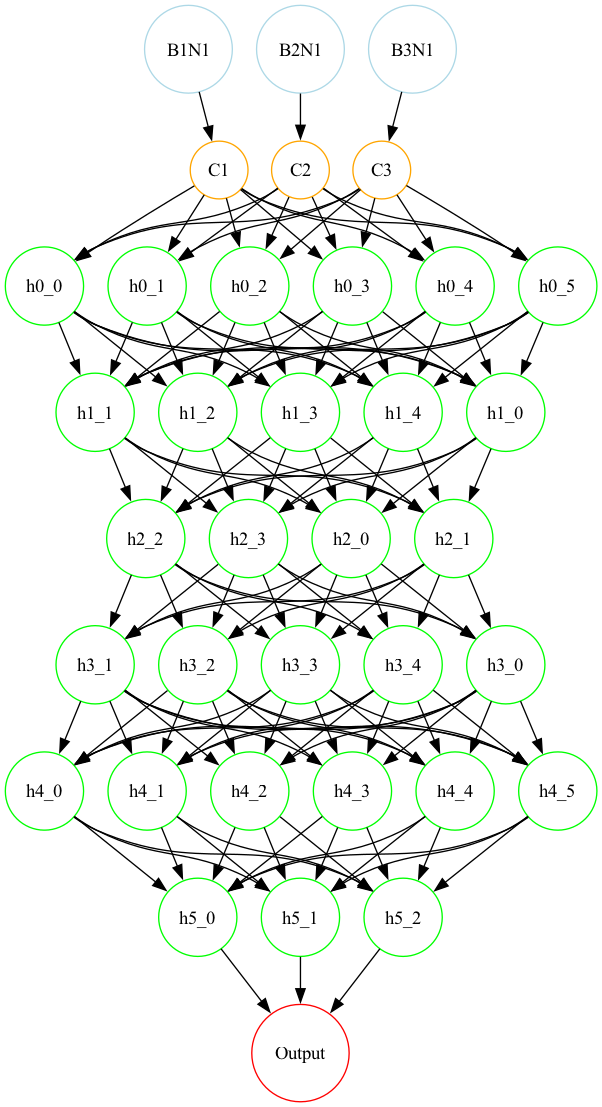

In [32]:
from graphviz import Digraph
from IPython.display import Image, display

def draw_branching_model():
    dot = Digraph(format='png')
    
    # Input branches (each branch outputs 1 neuron)
    for i, branch_size in enumerate([1,1,1]):
        with dot.subgraph() as s:
            s.attr(rank='same')
            for n in range(branch_size):
                s.node(f'input{i}_{n}', f'B{i+1}N{n+1}', shape='circle', color='lightblue')
    
    # Concatenation layer (3 neurons)
    with dot.subgraph() as s:
        s.attr(rank='same')
        for n in range(3):
            s.node(f'concat_{n}', f'C{n+1}', shape='circle', color='orange')
    
    # Connect branches to concat
    for i in range(3):
        dot.edge(f'input{i}_0', f'concat_{i}')
    
    # Final hidden layers: [6,5,4,5,6,3]
    hidden_layers = [6,5,4,5,6,3]
    prev_layer = [f'concat_{n}' for n in range(3)]
    for l_idx, size in enumerate(hidden_layers):
        layer_nodes = [f'h{l_idx}_{n}' for n in range(size)]
        for node in layer_nodes:
            dot.node(node, node, shape='circle', color='green')
        # Fully connect previous layer to current
        for prev in prev_layer:
            for curr in layer_nodes:
                dot.edge(prev, curr)
        prev_layer = layer_nodes
    
    # Output neuron
    dot.node('output', 'Output', shape='circle', color='red')
    for prev in prev_layer:
        dot.edge(prev, 'output')
    
    # Render to file
    filename = dot.render('branching_model', format='png')
    print(f"Neuron-level branching graph saved as {filename}")
    
    # Display in notebook
    display(Image(filename))

draw_branching_model()

In [33]:
model.final.bias

Parameter containing:
tensor([0.0625], requires_grad=True)

In [34]:
model.final.weight

Parameter containing:
tensor([[-0.2457, -0.0941, -0.2366]], requires_grad=True)

In [35]:
summary(
    model,
    input_data=(
        torch.rand(10, f1.shape[1]),
        torch.rand(10, f2.shape[1]),
        torch.rand(10, f3.shape[1])
    )
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [10, 1]                   --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 1]                   6
│    └─ReLU: 2-2                         [10, 1]                   --
├─Sequential: 1-2                        [10, 1]                   --
│    └─Linear: 2-3                       [10, 1]                   6
│    └─ReLU: 2-4                         [10, 1]                   --
├─Sequential: 1-3                        [10, 1]                   --
│    └─Linear: 2-5                       [10, 1]                   7
│    └─ReLU: 2-6                         [10, 1]                   --
├─Sequential: 1-4                        [10, 3]                   --
│    └─Linear: 2-7                       [10, 6]                   24
│    └─ReLU: 2-8                         [10, 6]                   --
│    └─Linear: 2-9

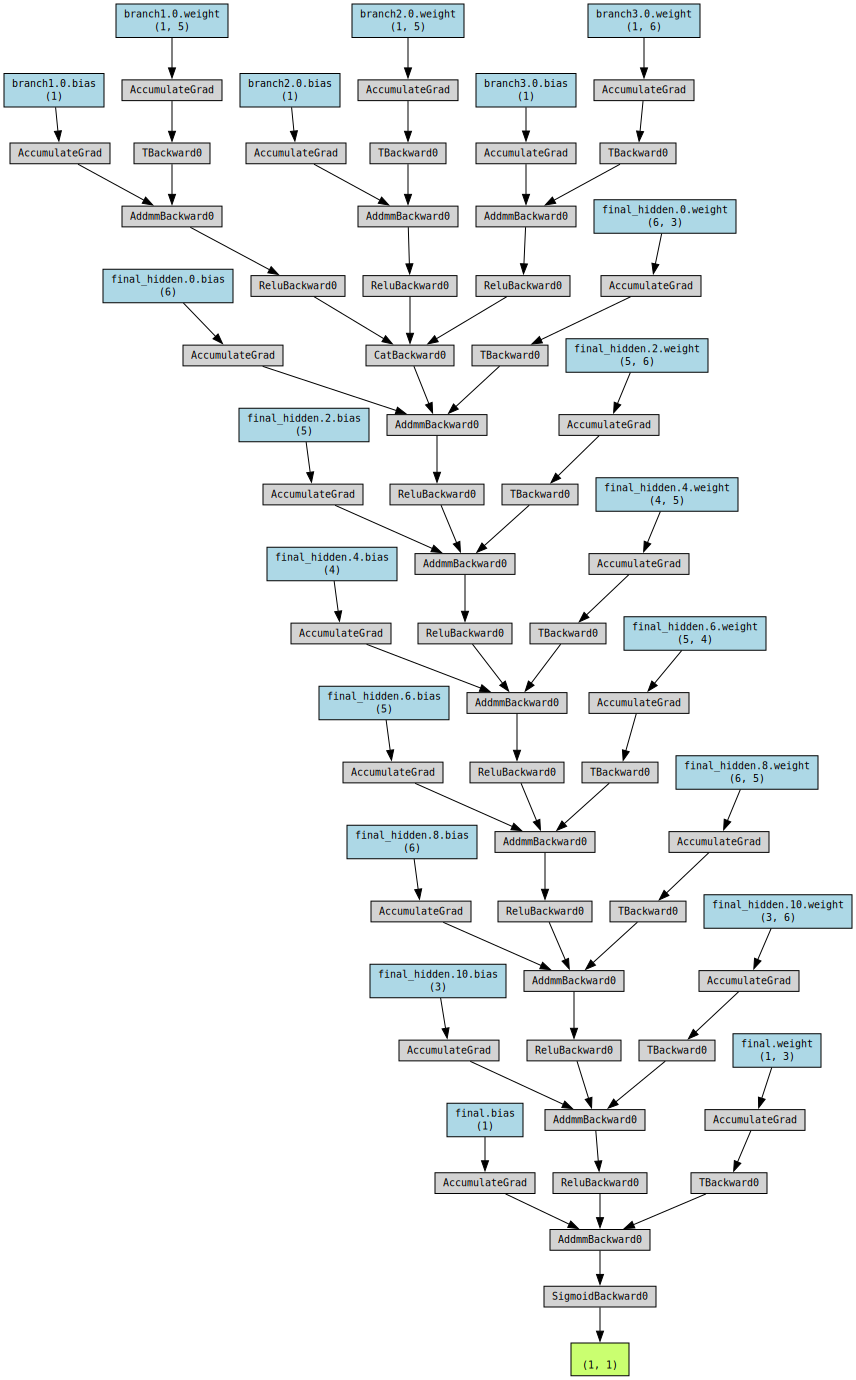

In [36]:
dot = make_dot(y, params=dict(model.named_parameters()))
display(Source(dot.source))